In [1]:
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import fmax as fm
import numpy as np

In [2]:
def plot_posterior_predictive(fcast_model, label):
    """Simple plot of the posterior predictive of a forecast model.
    """

    sample_paths = fcast_model.posterior_predictive_samples
    index = fcast_model.train_index

    # Calculate the 1%, 10%, 50%, 90%, and 99% quantiles
    lower_bound_one = np.quantile(sample_paths, q=0.01, axis=0)
    lower_bound_ten = np.quantile(sample_paths, q=0.1, axis=0)
    medians = np.quantile(sample_paths, q=0.5, axis=0)
    upper_bound_ninety = np.quantile(sample_paths, q=0.9, axis=0)
    upper_bound_ninety_nine = np.quantile(sample_paths, q=0.99, axis=0)

    # Plot
    fig, axs = plt.subplots(figsize=(13,8))

    axs.fill_between(index, lower_bound_one, upper_bound_ninety_nine, alpha=0.4, label="99% CI", color="C0")
    axs.fill_between(index, lower_bound_ten, upper_bound_ninety, alpha=0.7, label="80% CI", color="C0")
    axs.plot(index, medians, label="Median")
    axs.plot(index, fcast_model.train_data, color="red", label="Training")
    axs.legend()
    axs.set_xlabel("Period")
    axs.set_ylabel("Record")
    axs.set_title(label)

    fig.tight_layout()

    return fig

In [3]:
def plot_forecast(fcast_model, test_data, label, actual):
    """Simple plot of the posterior predictive of a forecast model.
    """

    sample_paths = fcast_model.forecast_samples
    index = fcast_model.master_with_fcast_index

    # Calculate the 1%, 10%, 50%, 90%, and 99% quantiles
    lower_bound_one = np.quantile(sample_paths, q=0.01, axis=0)
    lower_bound_ten = np.quantile(sample_paths, q=0.1, axis=0)
    medians = np.quantile(sample_paths, q=0.5, axis=0)
    upper_bound_ninety = np.quantile(sample_paths, q=0.9, axis=0)
    upper_bound_ninety_nine = np.quantile(sample_paths, q=0.99, axis=0)

    # Plot
    fig, axs = plt.subplots(figsize=(13,8))
    
    axs.fill_between(index, lower_bound_one, upper_bound_ninety_nine, alpha=0.4, label="99% CI", color="C0")
    axs.fill_between(index, lower_bound_ten, upper_bound_ninety, alpha=0.7, label="80% CI", color="C0")
    axs.plot(index, medians, label="Median")
    axs.plot(fcast_model.train_index, fcast_model.train_data, color="red", label="Training")
    axs.plot(fcast_model.fcast_index, test_data, color="black", label="Tryfos")
    axs.plot(fcast_model.fcast_index, actual, color="green", label="Actual")
    axs.legend()
    axs.set_xlabel("Period")
    axs.set_ylabel("Record")
    axs.set_title(label)

    fig.tight_layout()

    return fig

# Gaussian

WARNING (theano.tensor.opt): Optimization Warning: The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, mu]


Sampling 1 chain for 5_000 tune and 20_000 draw iterations (5_000 + 20_000 draws total) took 27 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, mu]


Sampling 1 chain for 5_000 tune and 20_000 draw iterations (5_000 + 20_000 draws total) took 29 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, mu]


Sampling 1 chain for 5_000 tune and 20_000 draw iterations (5_000 + 20_000 draws total) took 30 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, mu]


Sampling 1 chain for 5_000 tune and 20_000 draw iterations (5_000 + 20_000 draws total) took 29 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


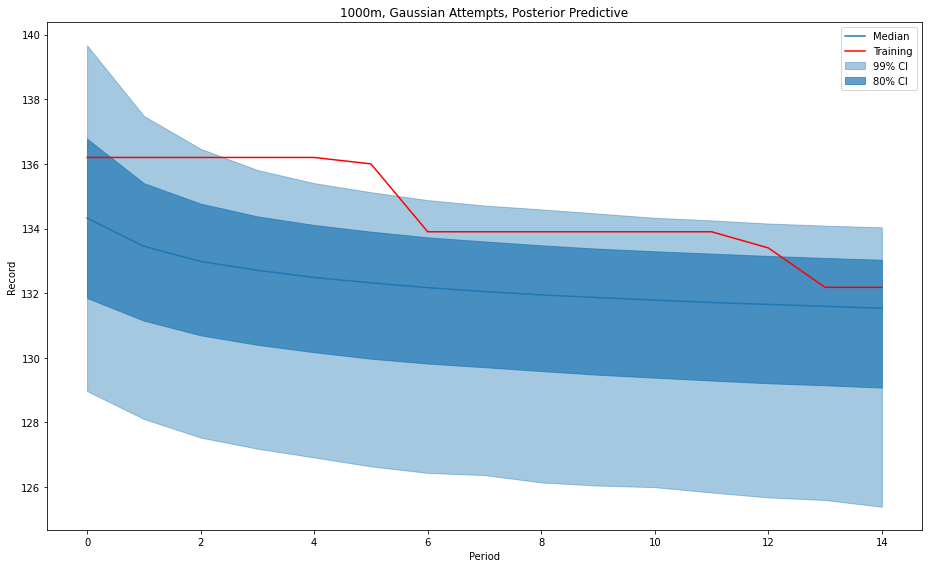

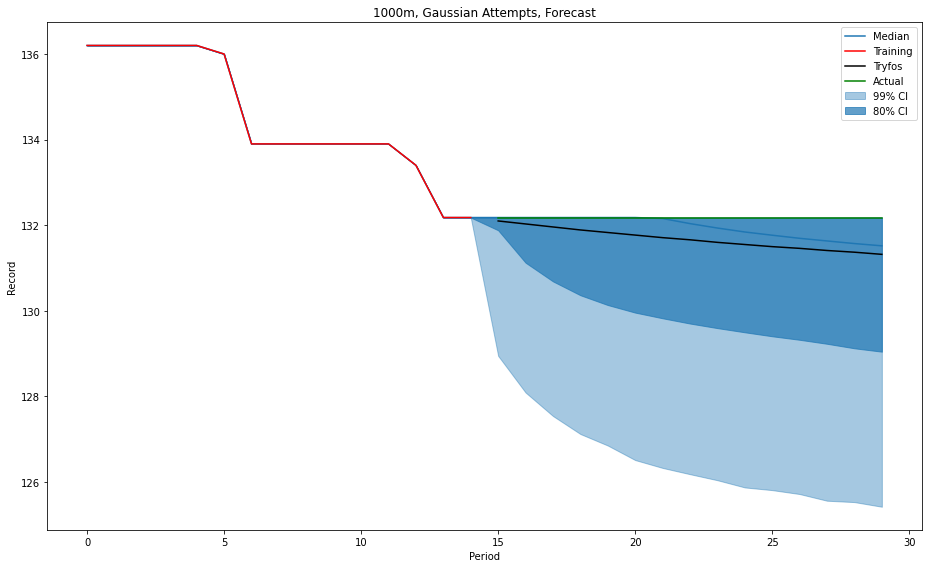

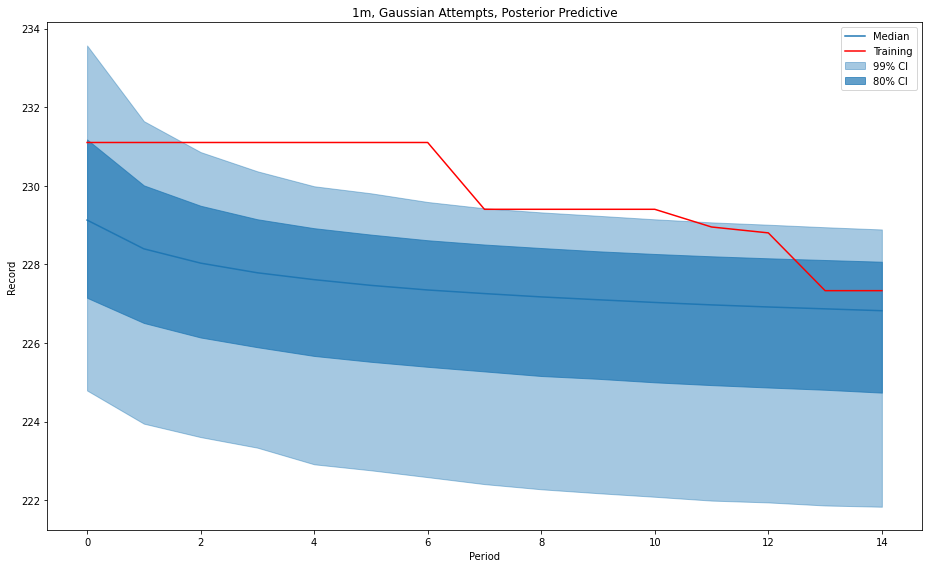

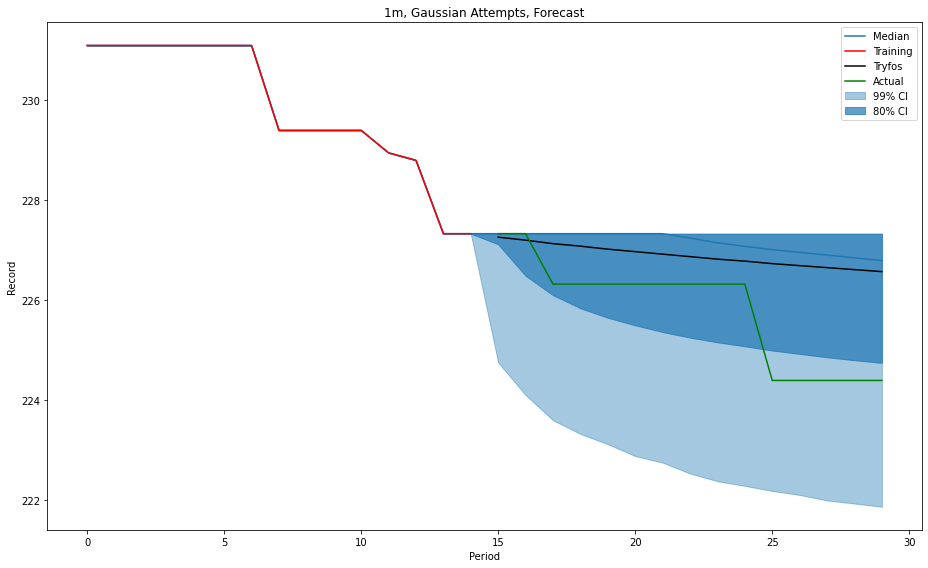

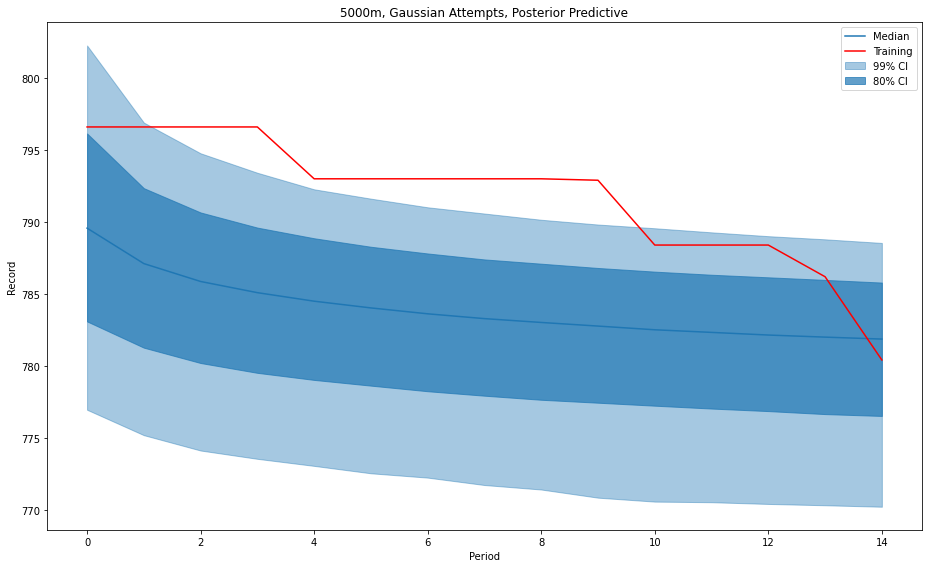

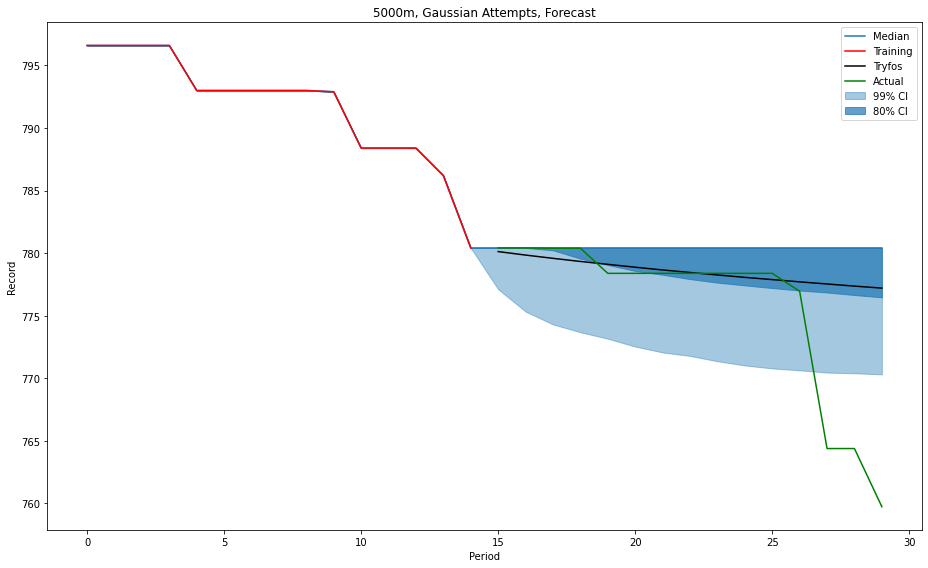

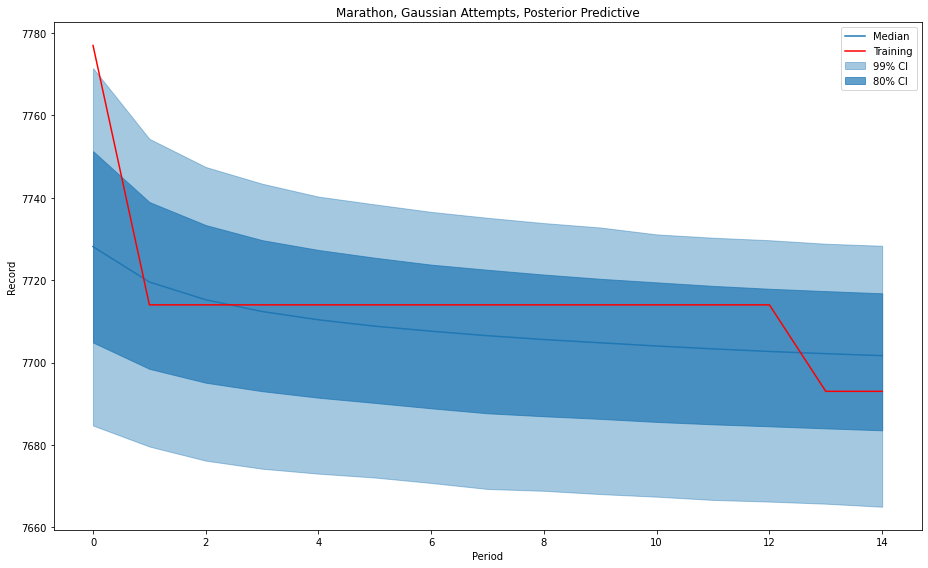

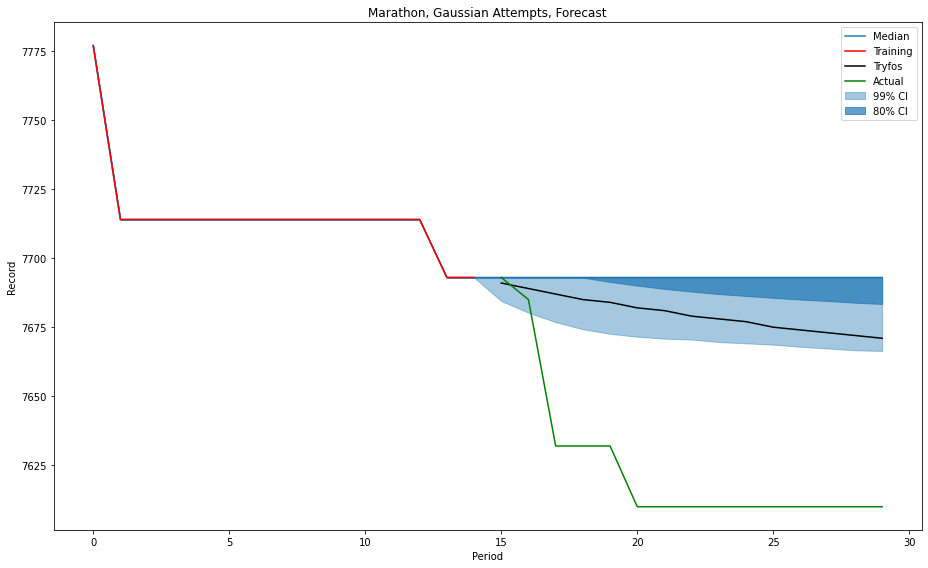

In [4]:
#whiches = ["1000m", "1m", "5000m", "Marathon", "10000m", "20000m"]
whiches = ["1000m", "1m", "5000m", "Marathon"]
#whiches = ["1000m"]

mses = {}
avg_log_probs = {}

fails = []

for which in whiches:
  try:
    df = pd.read_csv("tryfos_data.csv")
    years, records = df["Year"].values, df[which].values # Years 1983 and onward are just forecasts

    actual_df = pd.read_csv("tryfos_actual.csv")
    _, actual_records = actual_df["Year"].values, actual_df[which].values

    training_years = years[:15]
    training_records = records[:15]
    tryfos_years = years[15:]
    tryfos_fcast = records[15:]

    prior_parameters = {
              'mu' : {
                'mean' : training_records[0],
                'std' : 0.05*training_records[0],
              },
              'sigma' : {
                'lam' : 1
              }
            }

    model = fm.NewForecastModel(training_records, prior_parameters=prior_parameters, attempt_distribution="gaussian", 
                                kind="min", train='all', fcast_len=len(tryfos_fcast), fcast_test_data=actual_records)
                                
    model.fit(chains=1)
    model.posterior_predictive()
    model.forecast()

    # MSE calculation
    median = np.quantile(model.forecast_samples[:,-15:], q=0.5, axis=0)
    bayes_mse = fm.mse(median, model.fcast_test_data)
    tryfos_mse = fm.mse(tryfos_fcast, model.fcast_test_data)
    mses[which] = (bayes_mse, tryfos_mse)

    # Average logp
    avg_log_probs[which] = np.mean(model.posterior_predictive_ppc["log_like_holdout"])


    # Plots
    fig = plot_posterior_predictive(model, f"{which}, Gaussian Attempts, Posterior Predictive")
    fig.savefig(f"{which}_gaussian_attempts_post_pred.png")

    fig = plot_forecast(model, tryfos_fcast, f"{which}, Gaussian Attempts, Forecast", actual_records)
    fig.savefig(f"{which}_gaussian_attempts_forecast.png")

  except:
    print(f"failed for {which}")
    fails.append(which)

In [5]:
mses

{'1000m': (0.113798530991551, 0.30973333333333847),
 '1m': (2.584232301945882, 1.9230733333333596),
 '5000m': (65.49352666666633, 43.3707066666667),
 'Marathon': (5341.133333333333, 3500.8)}

In [7]:
avg_log_probs

{'1000m': -2.512502300942818,
 '1m': -14.449838462740667,
 '5000m': -66.45777078682518,
 'Marathon': -72.28102898998262}

# Gumbel

In [4]:
whiches = ["1000m", "1m", "5000m", "Marathon"]

mses = {}
avg_log_probs = {}

fails = []

#whiches = ["1000m"]
for which in whiches:

    df = pd.read_csv("tryfos_data.csv")
    years, records = df["Year"].values, df[which].values # Years 1983 and onward are just forecasts

    training_years = years[:15]
    training_records = records[:15]
    tryfos_years = years[15:]
    tryfos_fcast = records[15:]

    actual_df = pd.read_csv("tryfos_actual.csv")
    _, actual_records = actual_df["Year"].values, actual_df[which].values

    prior_parameters = {
            'mu' : {
            'mean' : training_records[0],
            'std' : 0.05*training_records[0],
            },
            'sigma' : {
            'lam' : 1
            }
        }

    model = fm.NewForecastModel(training_records, prior_parameters=prior_parameters, attempt_distribution="gumbel", 
                                kind="min", train='all', fcast_len=len(tryfos_fcast), fcast_test_data=actual_records)
    model.fit(chains=1)
    model.posterior_predictive()
    model.forecast()

    # MSE calculation
    median = np.quantile(model.forecast_samples[:,-15:], q=0.5, axis=0)
    bayes_mse = fm.mse(median, model.fcast_test_data)
    tryfos_mse = fm.mse(tryfos_fcast, model.fcast_test_data)
    mses[which] = (bayes_mse, tryfos_mse)

    # Average logp
    avg_log_probs[which] = np.mean(model.posterior_predictive_ppc["log_like_holdout"])


    # Plots
    fig = plot_posterior_predictive(model, f"{which}, Gumbel Attempts, Posterior Predictive")
    fig.savefig(f"{which}_gumbel_attempts_post_pred.png")

    fig = plot_forecast(model, tryfos_fcast, f"{which}, Gumbel Attempts, Forecast", actual_records)
    fig.savefig(f"{which}_gumbel_attempts_forecast.png")

    #except:
    #    print(f"Error: failed on {which}")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, mu]


C:\Users\Jonathan\miniconda3\envs\pm3env\lib\site-packages\pymc3\step_methods\hmc\quadpotential.py:224: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
C:\Users\Jonathan\miniconda3\envs\pm3env\lib\site-packages\pymc3\step_methods\hmc\quadpotential.py:203: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


ValueError: Mass matrix contains zeros on the diagonal. 
The derivative of RV `sigma_log__`.ravel()[0] is zero.
The derivative of RV `mu`.ravel()[0] is zero.

# Weibull

In [60]:
fm.util.weibull_mu_and_sigma(0.8, 10)

(11.330030963193462, 111.17079606495737)

In [5]:
which = "1000m"
df = pd.read_csv("tryfos_data.csv")
years, records = df["Year"].values, df[which].values # Years 1983 and onward are just forecasts

training_years = years[:15]
training_records = records[:15]
tryfos_years = years[15:]
tryfos_fcast = records[15:]

In [6]:
training_records

array([136.2 , 136.2 , 136.2 , 136.2 , 136.2 , 136.  , 133.9 , 133.9 ,
       133.9 , 133.9 , 133.9 , 133.9 , 133.4 , 132.18, 132.18])

In [ ]:
whiches = ["1000m", "1m", "5000m", "Marathon"]

for which in whiches:
    try:
        df = pd.read_csv("tryfos_data.csv")
        years, records = df["Year"].values, df[which].values # Years 1983 and onward are just forecasts

        training_years = years[:15]
        training_records = records[:15]
        tryfos_years = years[15:]
        tryfos_fcast = records[15:]

        prior_parameters = {
                'mu' : {
                'mean' : training_records[0],
                'std' : 0.05*training_records[0],
                },
                'sigma' : {
                'lam' : 1
                }
            }

        model = fm.NewForecastModel(training_records, prior_parameters=prior_parameters, attempt_distribution="gumbel", kind="min", train='all', fcast_len=len(tryfos_fcast))
        model.fit(chains=1)
        model.posterior_predictive()
        model.forecast()
        
        actual_df = pd.read_csv("tryfos_actual.csv")
        _, actual_records = actual_df["Year"].values, actual_df[which].values

        fig = plot_posterior_predictive(model, f"{which}, Gumbel Attempts, Posterior Predictive")
        fig.savefig(f"{which}_gumbel_attempts_post_pred.png")

        fig = plot_forecast(model, tryfos_fcast, f"{which}, Gumbel Attempts, Forecast", actual_records)
        fig.savefig(f"{which}_gumbel_attempts_forecast.png")
    
    except:
        print(f"Error: failed on {which}")